In [63]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import scipy
from moss import glm
import matplotlib.pyplot as plt
import nibabel as nib
%matplotlib inline

In [268]:
start_offset = 12 #saturation time
tr = 2
green_dot_time = 2 #time before choice is presented
decision_duration = 3 #including feedback
n_best_models = 6 #number of models to keep
ntrials = 24
nmodels = 1000 #number of models to make

#iti params
mean_iti = 7
min_iti = 3 #min 1 plus 2 seconds for green dot
max_iti = 14

#isi params (between choice and response cue)
mean_isi = 6
min_isi = 4
max_isi = 14

In [270]:
def get_isi(mean_isi, min_isi, max_isi, ntrials):
    isis = np.random.poisson(lam = mean_isi, size=ntrials*5)
    isis = [x for x in isis if x <= max_isi and x >= min_isi]
    return np.array(isis[0:ntrials])

In [311]:
def get_efficiency(contrast = None):
    #set up experimental timing
    isi = get_isi(mean_isi, min_isi, max_isi, ntrials)
    iti = get_isi(mean_iti,min_iti, max_iti, ntrials)

    choice_times = []
    decision_times = []
    for i in range(ntrials):
        if i == 0:
            choice_times.append(start_offset)
        else:
            choice_times.append(decision_times[-1] + decision_duration + iti[i])

        decision_times.append(choice_times[-1] + isi[i])

    #build design
    design = pd.DataFrame({'condition':['choice']*ntrials + ['decision']*ntrials,
                      'onset': choice_times + decision_times,
                      'duration': [0]*ntrials + [3]*ntrials,
                     })

    #convolve 
    hrf = glm.GammaDifferenceHRF()
    ntp = (decision_times[-1] + 12)/2
    model = glm.DesignMatrix(design = design, tr = tr, ntp = ntp, hrf_model = hrf, hpf_cutoff = 128)
    X = model.design_matrix.values
    
    #get efficiency
    XX = np.linalg.inv((X.T).dot(X))
    if contrast is None:
        eff = 1 / np.trace(XX)
    else:
        contrast = np.array(contrast)
        c = contrast.dot(XX).dot(contrast.T)
        eff = 1 / c
        
    return design,np.log(eff)

In [312]:
#enumerate lots of models
model_list = []
for i in range(nmodels):
    model_list.append(get_efficiency([1,0]))

In [297]:
model_list.sort(key=lambda x: x[1],reverse=True) #sort

(array([   8.,   31.,   74.,  152.,  244.,  254.,  143.,   77.,   13.,    4.]),
 array([-4.68878919, -4.63822992, -4.58767065, -4.53711139, -4.48655212,
        -4.43599285, -4.38543359, -4.33487432, -4.28431505, -4.23375579,
        -4.18319652]),
 <a list of 10 Patch objects>)

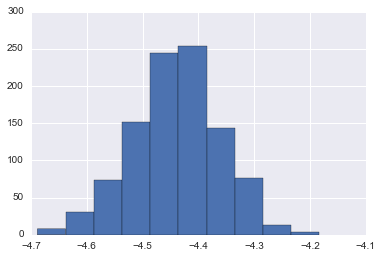

In [313]:
#plot efficiencies
effs = [x[1] for x in model_list]
plt.hist(effs)

In [314]:
#save top models
for i in range(n_best_models):
    out_f = os.path.abspath('timing/run' + str(i) + '.csv')
    model = model_list[i][0]
    model.to_csv(out_f,index = False)